In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/slabban/anaconda3/lib/python3.8/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
from fastai.vision.all import *
from fastbook import *

In [3]:
# For this particular notebook, we will be working with training some regression models
# Regression is reffered to when we want to train our dataset to recognize continous or countable values
# For this exercise we will be training a model that can pinpoint the center of a person's head
# Where the continous dependent variables are represented by the coordinates of the center of the head
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
# There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed)
# and a corresponding .obj file for each, we won't need them here.
# Let's take a look inside one of these directories

(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [7]:
# For this exercise we are only intersted in the rgb images and corrseponding pose files
# We get all the image in our path with fastai's 'get_image_files' func tion and write a function
# to take the image name and return the path to our associated pose file using our handy regex

img_files = get_image_files(path)

def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])


Path('05/frame_00396_pose.txt')

In [8]:
torch.typename(img_files)

'fastcore.foundation.L'

In [9]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

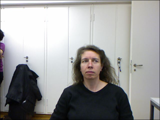

In [10]:
im.to_thumb(160)

In [11]:
# We copy/pasta some formula for finding the center of the head

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [12]:
get_ctr(img_files[0])

tensor([369.9407, 255.5367])

In [13]:
# We create our Datablock, not how we can pass in functions as arguments, such as get_ctr
# The data augmentation that fastai provides actually allows for the PointBlock coordinates
# to adjust the center of the head

# For our splitter we choose to validate using one person

biwi = DataBlock(blocks=(ImageBlock, PointBlock), get_items = get_image_files, get_y = get_ctr,
                 splitter= FuncSplitter(lambda o: o.parent.name == '13'),
                 batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)])
        

In [14]:
# We create our dataloaders 

dls = biwi.dataloaders(path)

/home/slabban/anaconda3/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


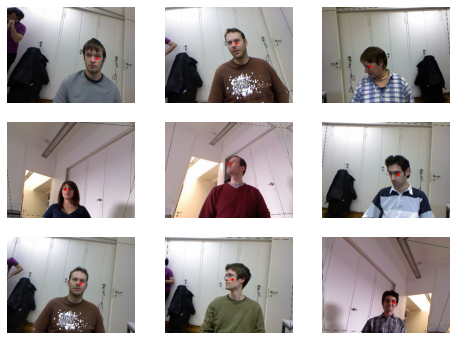

In [15]:
# Per good practice we vizualise some of our batches

dls.show_batch(max_n=9, figsize=(8,6), unique=False)

In [16]:
# Per another good practice, we vizualize our batch shape

# xb = (batch size, color chanels, x, y) ; yb = (batch size, pixel coordinate 1, pixel coordinate 2)

xb,yb = dls.one_batch()

xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [17]:
xb[0], yb[0]

(TensorImage([[[-0.0127, -0.0127,  0.0416,  ..., -0.3106, -0.3041, -0.2931],
          [-0.0127, -0.0127,  0.0247,  ..., -0.3337, -0.3299, -0.3244],
          [-0.0281, -0.0127, -0.0314,  ..., -0.2989, -0.3009, -0.3052],
          ...,
          [-0.0804, -0.0260,  0.0310,  ..., -0.9108, -0.9097, -0.9455],
          [-0.0725, -0.0403,  0.0310,  ..., -1.0522, -1.0556, -1.0531],
          [-0.0717, -0.0398,  0.0245,  ..., -1.3899, -1.4062, -1.4086]],
 
         [[ 0.0217,  0.0217,  0.0198,  ..., -0.3135, -0.3070, -0.2960],
          [ 0.0217,  0.0217,  0.0030,  ..., -0.3366, -0.3328, -0.3273],
          [ 0.0062,  0.0217,  0.0030,  ..., -0.3018, -0.3038, -0.3081],
          ...,
          [-0.1202, -0.0662, -0.0096,  ..., -0.8042, -0.8483, -0.8845],
          [-0.1265, -0.0804, -0.0095,  ..., -0.9683, -0.9958, -0.9932],
          [-0.1266, -0.0837, -0.0171,  ..., -1.3606, -1.3530, -1.3523]],
 
         [[ 0.1695,  0.1326,  0.1861,  ..., -0.2290, -0.2228, -0.2121],
          [ 0.1343,  0.

In [18]:
# We create our learner

learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/home/slabban/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
# The y_range is used when we are training our dependent variable for regression models
# -1 to 1 is the pytorch standard for specifiying the desired range and uses the sigmoid_range function

def sigmoid_range(x, lo, hi): return torch.sigmoid(x)*(hi-lo)+lo

/home/slabban/anaconda3/lib/python3.8/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


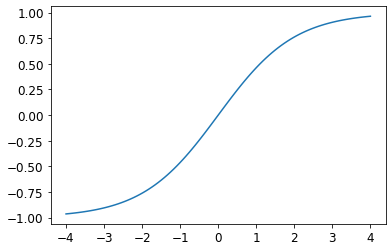

In [22]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [23]:
# The loss function is automatically chosen as Mean Squared Error

dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

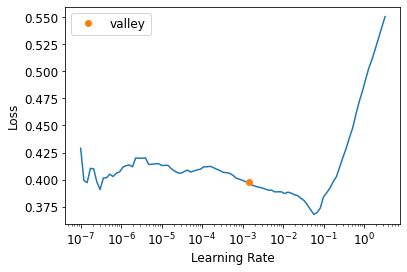

In [24]:
learn.lr_find()

In [25]:
# Using the suggested lr

lr = 0.0014454397605732083
learn.fine_tune(3, 0.0014454397605732083)


epoch,train_loss,valid_loss,time
0,0.178774,0.025025,02:02


epoch,train_loss,valid_loss,time
0,0.029907,0.000714,02:46
1,0.005919,0.001626,02:42
2,0.003914,0.001190,02:38


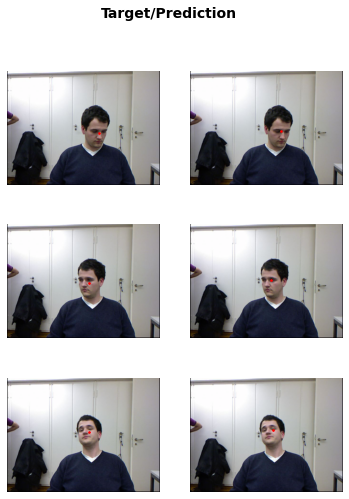

In [27]:
# With our model trained, we can use the function below to perform a quick sanity test and see
# How well our model has been trained, some pretty decent results are shown below

learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))